<a href="https://colab.research.google.com/github/hikmatfarhat-ndu/pytorch/blob/main/convolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# What you will learn
1. Convulational layers and the convolution operation
1. Pooling layers
1. Confusion matrix 

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision as vision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

## Convolutional Network

Convolutional neural network are very successfully in computer vision applications. They have the ability to progressively detect patterns in images and videos. Usually, the first few layers detect "low level" features such as lines and edges and, building on those, later layers detect more complicated features such as faces and objects.

### Convolution Operations
We start with a simple example. Let I be an input image. Typically $I$ would be represented by a tensor of shape $(H,W,C)$ where $H$, $W$, and $C$ are the height, width, and color channel respectively. Therefore,  $I[h,w,c]$ refers to the value of channel $c$ in pixel $(h,w)$. Let $K$ be a filter with shape $(m,n)$ then the convolution operation produces the following tensor
\begin{align*}
T_{i,j}=\sum_c\sum_{m,n}X_{i+m,j+n,c}*K_{m,n}
\end{align*}
The above operation is illustrated in the example below. Click on the figures to see the sequence of operations.


In [2]:

%%HTML
<iframe src="https://docs.google.com/presentation/d/e/2PACX-1vQBSo0SLsiigeXPOP4MGOS55ez9hvRT0xWocjs16K7U4JMTD1UnHXrNAu43qRo_GQ/embed?start=true&loop=true&delayms=3000" frameborder="0" width="500" height="300" allowfullscreen="true" mozallowfullscreen="true" webkitallowfullscreen="true"></iframe>

## Pooling
Pooling replaces a region of the input with a "summary" statistic, usually the maximum. This makes the computation almost translation invariant.

### Pooling example

In the example below, notice how the MaxPool2D picks the maximum from each 2x2 submatrix

In [3]:
input=torch.tensor([[1,2,4,3],[5,6,8,7],[9,10,12,11],[13,14,16,2]]).float()
# 1 sample, 1 channel, 4 height, 4 width
input=input.reshape([1,1,4,4])
output=nn.MaxPool2d(kernel_size=(2,2))(input)
print(input.squeeze())
print(output.squeeze())

tensor([[ 1.,  2.,  4.,  3.],
        [ 5.,  6.,  8.,  7.],
        [ 9., 10., 12., 11.],
        [13., 14., 16.,  2.]])
tensor([[ 6.,  8.],
        [14., 16.]])


## Data
The data is CIFAR10 with 50000 images for training and 10000 for testing. Each images has 3 channels and size 32x32.
As we have done before we convert the PIL images to tensor and then normalize the values. Since there are 3 channels we need 3 values for the mean and 3 for the standard deviation

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [5]:
dataset_train=vision.datasets.CIFAR10(".",download=True,train=True,transform=transform)
dataset_test=vision.datasets.CIFAR10(".",download=True,train=False,transform=transform)
loader_train=DataLoader(dataset_train,batch_size=64,shuffle=True,num_workers=2)
loader_test=DataLoader(dataset_test,batch_size=512,shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


## Model

Our model uses a stack of convolutional and pooling layers. Try to do the calculation of input/ouput sizes.
The last two layers are fully connected with the size of the ouput of the last one 10 = number of classes
Note that the ouput of convulational layers a "3-d" objects so we need to "flatten" then before feeding them to the fully connected layers 

In [6]:
class Net(nn.Module):
  def __init__(self):
    super().__init__()
    # input is (*,3,32,32)
    self.conv1=nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3)
    self.relu=nn.ReLU()
    # input is (*,32,30,30)
    self.pool1=nn.MaxPool2d(kernel_size=(2,2))
    # input is (*,32,15,15)
    self.conv2=nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3)
    # input is (*,64,13,13)
    self.pool2=nn.MaxPool2d(kernel_size=(2,2))
    # input is (*,64,6,6)
    self.conv3=nn.Conv2d(in_channels=64,out_channels=64,kernel_size=3)
    # input is (*,64,4,4)
    self.pool3=nn.MaxPool2d(kernel_size=(2,2))
    # input is (*,64,2,2)
    self.flatten=nn.Flatten()
    # input is (*,64x2x2)
    self.fc1=nn.Linear(in_features=2*2*64,out_features=64)
    self.fc2=nn.Linear(in_features=64,out_features=10)

  def forward(self,x):
    x=self.conv1(x)
    x=self.relu(x)
    x=self.pool1(x)

    x=self.conv2(x)
    x=self.relu(x)
    x=self.pool2(x)
    
    x=self.conv3(x)
    x=self.relu(x)
    x=self.pool3(x)
    
    x=self.flatten(x)
    x=self.fc1(x)
    x=self.relu(x)
    x=self.fc2(x)
    return x
    

In [7]:
model=Net().cuda()

In [8]:
loss_fn=nn.CrossEntropyLoss()
from torch.optim import SGD,Adam

In [9]:
#optimizer=SGD(model.parameters(),lr=0.005)
optimizer=Adam(model.parameters())

In [10]:
epochs=10
from tqdm import tqdm
for epoch in range(epochs):
  loader_train=tqdm(loader_train)
  for i, (imgs,labels) in enumerate(loader_train,0):
    optimizer.zero_grad()
    imgs=imgs.cuda()
    labels=labels.cuda()
    outputs=model(imgs)
    loss=loss_fn(outputs,labels)
    loss.backward()
    optimizer.step()
  print(loss.item()) 

100%|██████████| 782/782 [00:17<00:00, 44.12it/s]


0.9356094002723694


100%|██████████| 782/782 [00:12<00:00, 61.45it/s]


1.6076292991638184


100%|██████████| 782/782 [00:12<00:00, 60.30it/s]


1.0174493789672852


100%|██████████| 782/782 [00:13<00:00, 58.16it/s]


1.1746737957000732


100%|██████████| 782/782 [00:13<00:00, 58.65it/s]


1.0132380723953247


100%|██████████| 782/782 [00:13<00:00, 59.46it/s]


0.46576282382011414


100%|██████████| 782/782 [00:13<00:00, 58.73it/s]


0.7613165974617004


100%|██████████| 782/782 [00:12<00:00, 60.24it/s]


0.5044052600860596


100%|██████████| 782/782 [00:13<00:00, 59.45it/s]


0.5825787782669067


100%|██████████| 782/782 [00:13<00:00, 58.37it/s]

0.7565302848815918


# Accuracy and confusion matrix

In [21]:
!pip install torchmetrics
from torchmetrics import ConfusionMatrix
conmat=ConfusionMatrix(num_classes=10)
conmat=conmat.cuda()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [22]:
total=0
correct=0
for data in loader_test:
  imgs,labels=data
  imgs=imgs.cuda()
  labels=labels.cuda()
  outputs=model(imgs)
  # the second return value is the index of the max i.e. argmax
  _,predicted=torch.max(outputs.data,1)
  total+=labels.size(0)
  correct+=(predicted==labels).sum()
  conmat.update(predicted,labels)


In [23]:
print(correct/total)

tensor(0.7187, device='cuda:0')


In [33]:
import matplotlib.pyplot as plt
import seaborn as sb

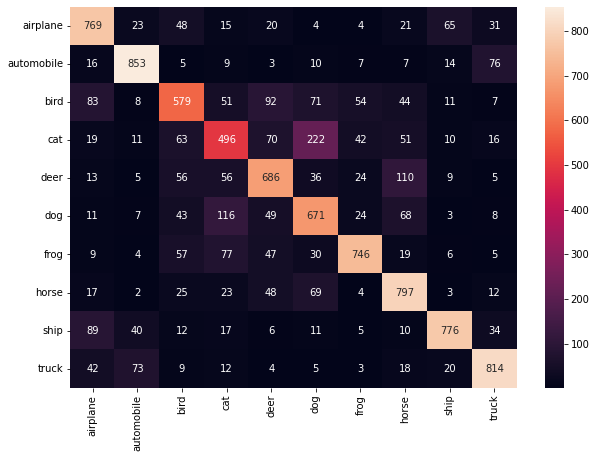

In [38]:
x=conmat.compute().cpu().numpy()
plt.figure(figsize=(10,7))
sb.heatmap(x,xticklabels=dataset_train.classes,yticklabels=dataset_train.classes,annot=True,fmt=".0f")